In [562]:
from IPython.display import clear_output
import pdb, time, math, numpy as np, gc, importlib, torch, os, cv2 as cv, ODEModel, matplotlib
import ot
import matplotlib.pyplot as plt
from torch import Tensor, nn
from torch.nn import functional as F 
from torch.autograd import Variable
from torch.distributions import MultivariateNormal
from torchdiffeq import odeint_adjoint as odeint 
from geomloss import SamplesLoss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import Utils, LearnVelTraj
importlib.reload(Utils)
from Utils import InputMapping, BoundingBox, ImageDataset, SaveTrajectory, ezshow, SaveTrajectory as st, MiscTransforms
importlib.reload(ODEModel)
from ODEModel import velocMLP, FfjordModel
importlib.reload(LearnVelTraj);
from LearnVelTraj import learn_vel_trajectory

(-0.962500023841858, 1.5124999761581421, -0.55, 0.55)

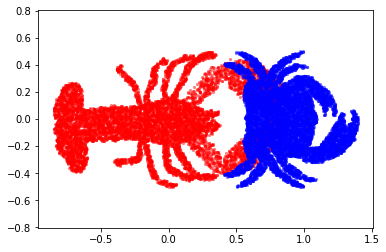

In [616]:
# # ## TRAIN carcination. jerk=.01
f1 = ImageDataset('frames/lobster.jpg',noise_std=0,thresh=.50,binary=False); 
f2 = ImageDataset('frames/crab.jpg',noise_std=0); 

n_inner = 10000;
n_sil = 10000 - n_inner;
dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1.7, -1], center = [0,0], rotate = 0),0); 
dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [1, -1], center = [.9,0], rotate = -np.pi/2),0); 

ezshow(dat1, col='red')
ezshow(dat2, col='blue')
plt.axis('equal')

keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));
model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_carcinization_base/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=True)
# model.load_state(outfolder + 'models/state_final.tar')

xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
                       nsteps=40, dpiv=600, n=2000)
st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
                       dpiv=600, sigma=None, knn=20, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=True)
st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_tight',
                       dpiv=600, sigma=None, knn=20, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=False)

0.002426508309240849
1.427077660352828
-0.00021900775189986899
1.0636208112539218


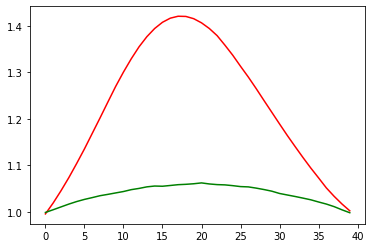

In [575]:
# # after running rect_base and rect_slight_div, run this to get areas.
# points = xt_trajs_1[0];
# areas = np.zeros(points.shape[2])
# for i in range(points.shape[2]):
#     chull = scipy.spatial.ConvexHull(points[:,:,i])
#     areas[i] = chull.volume
# areas1=areas

# points = xt_trajs_2[0];
# areas = np.zeros(points.shape[2])
# for i in range(points.shape[2]):
#     chull = scipy.spatial.ConvexHull(points[:,:,i])
#     areas[i] = chull.volume
# areas2=areas

# print(areas1[-1]-areas1[0]) 
# print(areas1.max()/areas1[0]) 

# print(areas2[-1]-areas2[0]) 
# print(areas2.max()/areas2[0]) 

# plt.plot(areas1/areas3[0],'r')
# plt.plot(areas2/areas3[0],'g')

# np.savetxt('results/outcache/areas1.txt', areas1)
# np.savetxt('results/outcache/areas2.txt', areas2)

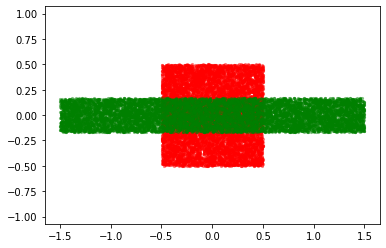

In [573]:
# # # # ## TRAIN rectangles. KE=.1, div=1
# n_inner = 10000;
# dat1 = torch.rand(n_inner,2)-.5
# dat2 = torch.rand(n_inner,2)-.5
# dat2[:,0]*=3;dat2[:,1]/=3;

# ezshow(dat1, col='red')
# ezshow(dat2, col='green')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));
# model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_rects_slight_div/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=True)
# model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=40, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=20, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=True)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_tight',
#                        dpiv=600, sigma=None, knn=20, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=False)
# xt_trajs_2 = xt_trajs

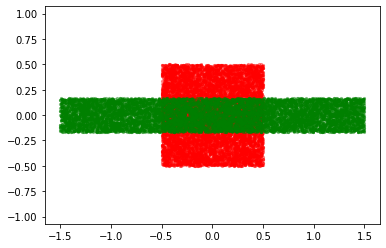

In [574]:
# # # ## TRAIN rectangles. KE=.1, div=0
# # optimal transport from (1,1) square to (.33,3) rectangle should result in an area increase of 33.3% at the middle of the trajectory.
# n_inner = 10000;
# dat1 = torch.rand(n_inner,2)-.5
# dat2 = torch.rand(n_inner,2)-.5
# dat2[:,0]*=3;dat2[:,1]/=3;

# ezshow(dat1, col='red')
# ezshow(dat2, col='green')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));
# model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_rects_base/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=True)
# model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=40, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=20, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=True)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_tight',
#                        dpiv=600, sigma=None, knn=20, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=False)
# xt_trajs_1 = xt_trajs

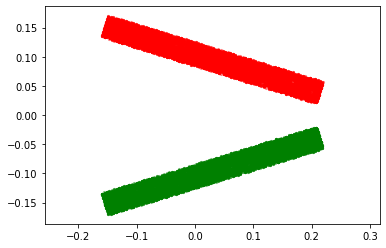

In [478]:
# # # ## TRAIN bars. KE=.01, rigid=10
# f1 = ImageDataset('frames/square.png',noise_std=0); 
# rotate = torch.tensor(.3)
# s, c = (torch.sin(rotate), torch.cos(rotate))
# rot = torch.stack([torch.stack([c, -s]), torch.stack([s, c])])

# n_inner = 10000;
# n_sil = 10000 - n_inner;
# dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, .1], center = [0, .1]),0); 
# dat2 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, .1], center = [0, -.1]),0); 
# dat1 = dat1 @ rot
# dat2 = dat2 @ rot.t()

# ezshow(dat1, col='red')
# ezshow(dat2, col='green')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));

# model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_bars_more_rigid/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=True)
# model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# # st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
# #                        dpiv=600, sigma=None, knn=20, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_tight',
#                        dpiv=600, sigma=None, knn=20, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=False)

In [477]:
# # ## TRAIN bars. KE=.01, rigid=1
# f1 = ImageDataset('frames/square.png',noise_std=0); 
# rotate = torch.tensor(.3)
# s, c = (torch.sin(rotate), torch.cos(rotate))
# rot = torch.stack([torch.stack([c, -s]), torch.stack([s, c])])

# n_inner = 10000;
# n_sil = 10000 - n_inner;
# dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, .1], center = [0, .1]),0); 
# dat2 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, .1], center = [0, -.1]),0); 
# dat1 = dat1 @ rot
# dat2 = dat2 @ rot.t()

# ezshow(dat1, col='red')
# ezshow(dat2, col='green')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));

# model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_bars_rigid/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=True)
# model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=20, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_tight',
#                        dpiv=600, sigma=None, knn=20, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=False)

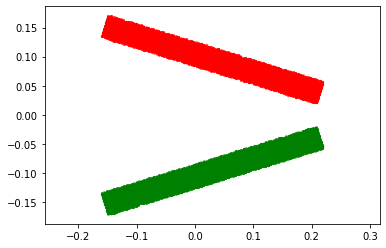

In [479]:
# # ## TRAIN bars. KE=.01
# f1 = ImageDataset('frames/square.png',noise_std=0); 
# rotate = torch.tensor(.3)
# s, c = (torch.sin(rotate), torch.cos(rotate))
# rot = torch.stack([torch.stack([c, -s]), torch.stack([s, c])])

# n_inner = 10000;
# n_sil = 10000 - n_inner;
# dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, .1], center = [0, .1]),0); 
# dat2 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, .1], center = [0, -.1]),0); 
# dat1 = dat1 @ rot
# dat2 = dat2 @ rot.t()

# ezshow(dat1, col='red')
# ezshow(dat2, col='green')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));

# model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_bars_base/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=True)
# model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# # st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
# #                        dpiv=600, sigma=None, knn=20, cycle=False, lw=3, contrast=3, Nrbf = 100000,keyframes=True)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_tight',
#                        dpiv=600, sigma=None, knn=20, cycle=False, lw=3, contrast=3, Nrbf = 100000, keyframes=True, tightBB=False)

In [177]:
# # horse down to horse up - jerk = .01
# im1 = ImageDataset('frames/horse1.jpg'); 
# im2 = ImageDataset('frames/horse2.jpg'); 
# n_inner = 7000;
# n_sil = 10000 - n_inner;
# d1 = im1.sample(n_inner, n_sil, center = [1, .5]); 
# d2 = im2.sample(n_inner, n_sil, center = [1, .5], scale=[-1, -1]); 
# dat1 = torch.cat(d1,0)
# dat2 = torch.cat(d2,0)
# ezshow(dat1, col='yellow')
# ezshow(dat2, col='red')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));
# model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_horseup_base/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)
# model.load_state(outfolder+'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# xt_trajs_OT = st.get_OT_trajectory(keyframes, nsteps=20, n=2000, ot_type=2)

# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=0, contrast=2, keyframes=False, Nrbf = 100000)

# st.render_2d(model, keyframes, xt_trajs_OT, savedir=outfolder, savename='OT_render',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=0, contrast=2, keyframes=False, Nrbf = 100000, Nqvr=1, showVelocity=False)


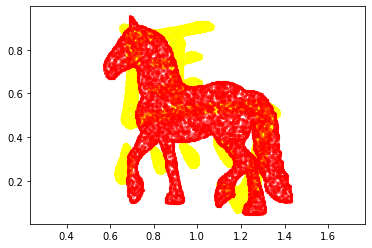

In [178]:
# # # horse character to horse - jerk = .01
# im1 = ImageDataset('frames/horse_charac.jpg'); 
# im2 = ImageDataset('frames/horse.jpg'); 

# n_inner = 7000;
# n_sil = 10000 - n_inner;
# d1 = im1.sample(n_inner, n_sil, center = [1, .5]); 
# d2 = im2.sample(n_inner, n_sil, center = [1, .5], scale=[-1, -1]); 

# dat1 = torch.cat(d1,0)
# dat2 = torch.cat(d2,0)

# ezshow(dat1, col='yellow')
# ezshow(dat2, col='red')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));

# model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_horse_base/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)
# model.load_state(outfolder+'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=0, contrast=3, keyframes=False, Nrbf = 100000)

# xt_trajs_OT = st.get_OT_trajectory(keyframes, nsteps=20, n=2000, ot_type=2)
# st.render_2d(model, keyframes, xt_trajs_OT, savedir=outfolder, savename='OT_render',
#                        dpiv=600, sigma=None, knn=15, cycle=False, lw=0, contrast=3, keyframes=False, Nrbf = 100000, Nqvr=1, showVelocity=False)


/mnt/pzpzpzp1/anaconda3/envs/wassflow/lib/python3.8/site-packages/ot/lp/__init__.py:329: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


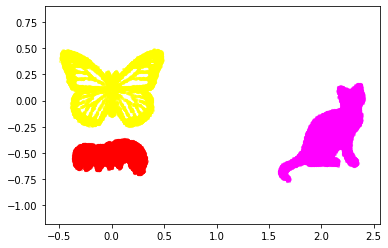

In [411]:
# # BUTTERFLY->CAT->CATERPILLAR - KE = .01, radialke = .1
# im1 = ImageDataset('frames/butterfly.jpg'); 
# im1b = ImageDataset('frames/butterflyfilled.jpg'); 
# im2 = ImageDataset('frames/caterpillar.png', noise_std = .005); 
# im6 = ImageDataset('frames/cat1.png'); 

# n_inner = 7000;
# n_sil = 10000 - n_inner;
# d2 = im2.sample(n_inner, n_sil, scale = [-1, -1], center = [0.05, -.5]); 
# d1a = im1.sample(n_inner, n_sil, center = [0, 0]); 
# d1b = im1b.sample(n_inner, n_sil, center = [0, 0]); 
# d6 = im6.sample(n_inner, n_sil, center = [2, -.3]); 

# dat1 = torch.cat((d1a[0], d1b[1]),0)
# dat2 = torch.cat(d2,0)
# dat6 = torch.cat(d6,0)

# ezshow(dat1, col='yellow')
# ezshow(dat2, col='red')
# ezshow(dat6, col='magenta')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2)).to(device));

# model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_BCC_radial/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)
# model.load_state(outfolder+'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=4000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=20, cycle=False, lw=1, contrast=3, Nrbf = 100000)

In [448]:
# # BUTTERFLY->CAT->CATERPILLAR - base. KE = .01
# im1 = ImageDataset('frames/butterfly.jpg'); 
# im1b = ImageDataset('frames/butterflyfilled.jpg'); 
# im2 = ImageDataset('frames/caterpillar.png', noise_std = .005); 
# im6 = ImageDataset('frames/cat1.png'); 

# n_inner = 7000;
# n_sil = 10000 - n_inner;
# d2 = im2.sample(n_inner, n_sil, scale = [-1, -1], center = [0.05, -.5]); 
# d1a = im1.sample(n_inner, n_sil, center = [0, 0]); 
# d1b = im1b.sample(n_inner, n_sil, center = [0, 0]); 
# d6 = im6.sample(n_inner, n_sil, center = [2, -.3]); 

# dat1 = torch.cat((d1a[0], d1b[1]),0)
# dat2 = torch.cat(d2,0)
# dat6 = torch.cat(d6,0)

# ezshow(dat1, col='yellow')
# ezshow(dat2, col='red')
# ezshow(dat6, col='magenta')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2)).to(device));

# model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_BCC_base/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)
# model.load_state(outfolder+'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=4000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=20, cycle=False, lw=1, contrast=3, Nrbf = 100000)

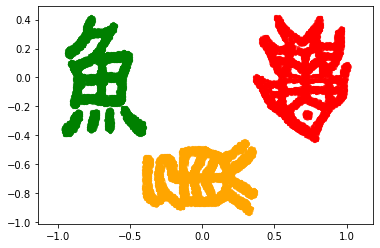

In [188]:
# ## TRAIN FISH234 cycle. Jerk=.01. signedcurl=.1 curl everywhere
# f2 = ImageDataset('frames/fish2.jpg',noise_std=0); 
# f3 = ImageDataset('frames/fish3.jpg',noise_std=0); 
# f4 = ImageDataset('frames/fish4.jpg',noise_std=0); 

# n_inner = 8000;
# n_sil = 10000 - n_inner;
# dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [.9, -1], center = [.7, 0], rotate = -np.pi),0); 
# dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [.9, -1.0], center = [0, -.7], rotate = np.pi/2),0); 
# dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [.95, -1.0], center = [-.7, 0], rotate = 0),0); 

# ezshow(dat2, col='red')
# ezshow(dat3, col='orange')
# ezshow(dat4, col='green')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat2, dat3, dat4)).to(device));

# model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_fish234_signedcurl_even/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)
# model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=30, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=12, cycle=False, lw=2, contrast=3, Nrbf = 100000)

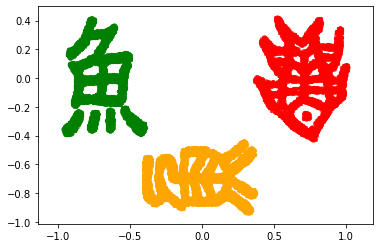

In [189]:
# ## TRAIN FISH234 cycle. Jerk=.01. signedcurl=.1 average curl
# f2 = ImageDataset('frames/fish2.jpg',noise_std=0); 
# f3 = ImageDataset('frames/fish3.jpg',noise_std=0); 
# f4 = ImageDataset('frames/fish4.jpg',noise_std=0); 

# n_inner = 8000;
# n_sil = 10000 - n_inner;
# dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [.9, -1], center = [.7, 0], rotate = -np.pi),0); 
# dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [.9, -1.0], center = [0, -.7], rotate = np.pi/2),0); 
# dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [.95, -1.0], center = [-.7, 0], rotate = 0),0); 

# ezshow(dat2, col='red')
# ezshow(dat3, col='orange')
# ezshow(dat4, col='green')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat2, dat3, dat4)).to(device));

# model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_fish234_signedcurl/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)
# model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=12, cycle=False, lw=2, contrast=3, Nrbf = 100000)

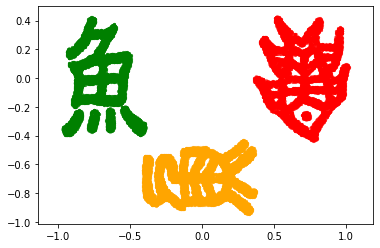

In [191]:
# ## TRAIN FISH234 cycle. Jerk=.01.
# f2 = ImageDataset('frames/fish2.jpg',noise_std=0); 
# f3 = ImageDataset('frames/fish3.jpg',noise_std=0); 
# f4 = ImageDataset('frames/fish4.jpg',noise_std=0); 

# n_inner = 8000;
# n_sil = 10000 - n_inner;
# dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [.9, -1], center = [.7, 0], rotate = -np.pi),0); 
# dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [.9, -1.0], center = [0, -.7], rotate = np.pi/2),0); 
# dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [.95, -1.0], center = [-.7, 0], rotate = 0),0); 

# ezshow(dat2, col='red')
# ezshow(dat3, col='orange')
# ezshow(dat4, col='green')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat2, dat3, dat4)).to(device));

# model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_fish234/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)
# model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=12, cycle=False, lw=2, contrast=3, Nrbf = 100000)

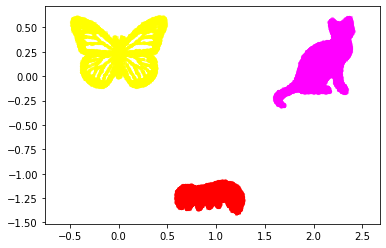

In [346]:
# ## GENERATE CYCLIC BUTTERFLY->CAT->CATERPILLAR. enforce completely cyclic.
# im1 = ImageDataset('frames/butterfly.jpg'); 
# im1b = ImageDataset('frames/butterflyfilled.jpg'); 
# im2 = ImageDataset('frames/caterpillar.png', noise_std = .005); 
# im6 = ImageDataset('frames/cat1.png'); 

# n_inner = 7000;
# n_sil = 10000 - n_inner;
# d2 = im2.sample(n_inner, n_sil, scale = [-1, -1], center = [1, -1.2]); 
# d1a = im1.sample(n_inner, n_sil, center = [0, .13]); 
# d1b = im1b.sample(n_inner, n_sil, center = [0, .13]); 
# d6 = im6.sample(n_inner, n_sil, center = [2, .15]); 

# dat1 = torch.cat((d1a[0], d1b[1]),0)
# dat2 = torch.cat(d2,0)
# dat6 = torch.cat(d6,0)

# ezshow(dat1, col='yellow')
# ezshow(dat2, col='red')
# ezshow(dat6, col='magenta')

# ## TRAIN CYCLIC BUTTERFLY->CAT->CATERPILLAR. .1 radial, .01 jerk
# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat6, dat2, dat1)).to(device));

# model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 4, in_features=3, out_features=2, incrementalMask = True,  Tperiod = len(keyframes)-1).to(device)
# outfolder = "results/experiment_BCC_cyclic/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)
# model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=20, cycle=True, lw=.5, contrast=3, Nrbf = 100000)

In [433]:
## TRAIN umbrella. Jerk=.01. poor temporal consistency because of discretized ot registration.
# f1 = ImageDataset('frames/birdflock_start.jpg',noise_std=0,thresh=.9,binary=False); 
# f2 = ImageDataset('frames/umbrella.jpg',noise_std=0,thresh=.9); 
# f3 = ImageDataset('frames/birdflock_end.jpg',noise_std=.1,thresh=1,binary=False); 

# # dat1 = torch.cat(f1.sample(1000, 0, scale = [1.5, -1.2], center = [-1.5, .125], rotate = 0),0); 
# # dat1 = torch.randn(1000,2); dat1[:,0]*=.5; dat1[:,1]*=.2; dat1[:,0]-=.6
# dat2 = torch.randn(1000,2); dat2[:,0]*=.2; dat2[:,1]*=.1; dat2[:,0]-=.2; dat2[:,1]+=.1
# dat1 = dat2.clone(); dat1[:,0]-=.5
# dat3 = torch.cat(f2.sample(900, 100, scale = [1, -1.1], center = [.13, -.05], rotate = 0),0); 
# dat4 = torch.cat(f3.sample(1000, 0, scale = [2, -2], center = [.2, .2], rotate = 0),0); 
# dat5 = torch.randn(1000,2); dat5[:,0]*=.8; dat5[:,1]*=.8; dat5[:,1]+=.5

# ezshow(dat1, col='yellow')
# ezshow(dat2, col='orange')
# ezshow(dat3, col='red')
# ezshow(dat4, col='blue')
# # ezshow(dat5, col='green')

# # keyframes = torch.stack((dat1, dat2, dat3, dat4, dat5)).to(device);
# keyframes = torch.stack((dat1, dat2, dat3, dat4)).to(device);

# model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_umbrella_base/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = True, lr = 1e-4, scaling = .4, normalize=False)
# model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=100)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render_points',
#                        dpiv=600, sigma=.01, knn=1, cycle=False, lw=.01, contrast=1, Nrbf = 0, keyframes=False, showVelocity=False, plotKeypoints=True)

  0%|          | 1/300 [00:01<06:17,  1.26s/it]

Allocated: 1.58 GB  Reserved: 15.63 GB
[Loss: 1.4283 | lr: 0.0001 | n_subsample: 300] 
[Total time : 1.2656 | Iter: 1.2646 | fit: 0.1615 | reg: 0.1441 | save: 0.0000) | autograd: 0.9565]


 17%|█▋        | 51/300 [01:06<11:51,  2.86s/it]

Allocated: 1.57 GB  Reserved: 15.63 GB
[Loss: 0.3371 | lr: 0.0001 | n_subsample: 378] 
[Total time : 66.6161 | Iter: 59.8440 | fit: 0.1636 | reg: 0.1170 | save: 5.5043) | autograd: 0.8742]


 34%|███▎      | 101/300 [02:12<09:20,  2.82s/it]

Allocated: 1.57 GB  Reserved: 15.63 GB
[Loss: 0.3396 | lr: 5e-05 | n_subsample: 476] 
[Total time : 132.4476 | Iter: 60.5799 | fit: 0.1658 | reg: 0.1524 | save: 5.2498) | autograd: 0.9734]


 50%|█████     | 151/300 [03:21<07:07,  2.87s/it]

Allocated: 1.57 GB  Reserved: 15.63 GB
[Loss: 0.3378 | lr: 5e-05 | n_subsample: 600] 
[Total time : 201.4681 | Iter: 63.7727 | fit: 0.1676 | reg: 0.1376 | save: 5.2468) | autograd: 0.9934]


 67%|██████▋   | 201/300 [04:33<04:56,  2.99s/it]

Allocated: 1.57 GB  Reserved: 15.63 GB
[Loss: 0.4077 | lr: 2.5e-05 | n_subsample: 756] 
[Total time : 273.1370 | Iter: 66.1828 | fit: 0.1910 | reg: 0.1483 | save: 5.4846) | autograd: 1.0452]


 84%|████████▎ | 251/300 [05:44<02:21,  2.89s/it]

Allocated: 1.57 GB  Reserved: 15.63 GB
[Loss: 0.3418 | lr: 1.25e-05 | n_subsample: 953] 
[Total time : 344.4157 | Iter: 66.0161 | fit: 0.1831 | reg: 0.1476 | save: 5.2610) | autograd: 0.9882]


 99%|█████████▉| 298/300 [06:47<00:02,  1.37s/it]


KeyboardInterrupt: 

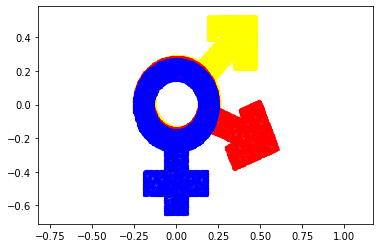

In [254]:
## TRAIN MF. Jerk=.01, div=1, rig.1
f1 = ImageDataset('frames/male.jpg',noise_std=0); 
f2 = ImageDataset('frames/female.jpg',noise_std=0); 

n_inner = 8000;
n_sil = 10000 - n_inner;
dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.1], center = [.11, .125], rotate = 0),0); 
dat2 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.1], center = [.13, -.05], rotate = -np.pi*.375),0); 
dat3 = torch.cat(f2.sample(n_inner, n_sil, scale = [1, -1.1], center = [0, -.2], rotate = 0),0); 

ezshow(dat1, col='yellow')
ezshow(dat2, col='red')
ezshow(dat3, col='blue')

keyframes = torch.stack((dat1, dat2, dat3)).to(device);

model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_MMF_rigdiv/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4, normalize=False)
# model.load_state(outfolder + 'models/state_final.tar')

xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
                       nsteps=20, dpiv=600, n=2000)
st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
                       dpiv=600, sigma=None, knn=10, cycle=True, lw=0, contrast=3, Nrbf = 100000,keyframes=False)

In [211]:
## TRAIN MF. Jerk=.01, 
# f1 = ImageDataset('frames/male.jpg',noise_std=0); 
# f2 = ImageDataset('frames/female.jpg',noise_std=0); 

# n_inner = 8000;
# n_sil = 10000 - n_inner;
# dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.1], center = [.2, .5], rotate = -np.pi/7),0); 
# dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [1, -1.1], center = [0, 0], rotate = 0),0); 

# ezshow(dat1, col='yellow')
# ezshow(dat2, col='red')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));

# model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 4, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_MF2_base/"
# # model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)
# model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=10, cycle=True, lw=0, contrast=3, Nrbf = 100000,keyframes=False)

/mnt/pzpzpzp1/wassflow/LearnVelTraj.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(meshSamplePoints).to(device).float())
  0%|          | 1/300 [00:01<05:04,  1.02s/it]

Allocated: 1.59 GB  Reserved: 15.63 GB
[Loss: 1.4142 | lr: 0.0001 | n_subsample: 300] 
[Total time : 1.0199 | Iter: 1.0185 | fit: 0.1609 | reg: 0.1128 | save: 0.0000) | autograd: 0.7416]


 17%|█▋        | 51/300 [01:09<12:36,  3.04s/it]

Allocated: 1.58 GB  Reserved: 15.63 GB
[Loss: 0.3441 | lr: 0.0001 | n_subsample: 378] 
[Total time : 69.6420 | Iter: 62.9471 | fit: 0.1868 | reg: 0.1372 | save: 5.6740) | autograd: 0.8993]


 34%|███▎      | 101/300 [02:25<10:08,  3.06s/it]

Allocated: 1.58 GB  Reserved: 15.63 GB
[Loss: 0.3578 | lr: 0.0001 | n_subsample: 476] 
[Total time : 145.1821 | Iter: 70.2046 | fit: 0.1969 | reg: 0.1716 | save: 5.3335) | autograd: 1.0983]


 50%|█████     | 151/300 [03:44<08:02,  3.24s/it]

Allocated: 1.58 GB  Reserved: 15.63 GB
[Loss: 0.4450 | lr: 5e-05 | n_subsample: 600] 
[Total time : 224.9955 | Iter: 74.2470 | fit: 0.2310 | reg: 0.1714 | save: 5.5647) | autograd: 1.1294]


 67%|██████▋   | 201/300 [05:10<05:29,  3.33s/it]

Allocated: 1.58 GB  Reserved: 15.63 GB
[Loss: 0.7271 | lr: 2.5e-05 | n_subsample: 756] 
[Total time : 310.1174 | Iter: 79.7126 | fit: 0.2286 | reg: 0.1603 | save: 5.4075) | autograd: 1.2425]


 84%|████████▎ | 251/300 [06:44<02:42,  3.32s/it]

Allocated: 1.58 GB  Reserved: 15.63 GB
[Loss: 0.4111 | lr: 1.25e-05 | n_subsample: 953] 
[Total time : 404.3090 | Iter: 88.8316 | fit: 0.2097 | reg: 0.1827 | save: 5.3577) | autograd: 1.3951]


100%|██████████| 300/300 [08:14<00:00,  1.65s/it]

Allocated: 1.58 GB  Reserved: 15.63 GB
[Loss: 0.3737 | lr: 6.25e-06 | n_subsample: 953] 
[Total time : 494.1192 | Iter: 84.2216 | fit: 0.2187 | reg: 0.1752 | save: 5.5872) | autograd: 1.2826]


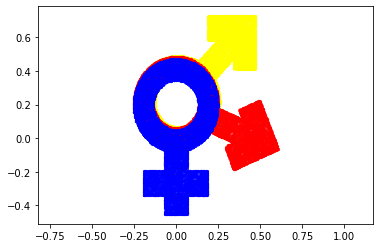

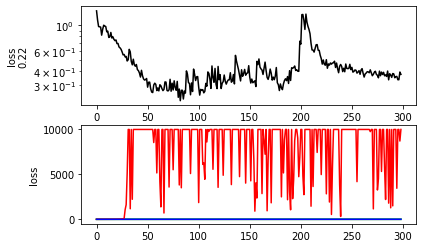

In [244]:
# ## TRAIN MF. Jerk=.01
# f1 = ImageDataset('frames/male.jpg',noise_std=0); 
# f2 = ImageDataset('frames/female.jpg',noise_std=0); 

# n_inner = 8000;
# n_sil = 10000 - n_inner;
# dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.1], center = [.11, .325], rotate = 0),0); 
# dat2 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.1], center = [.13, .15], rotate = -np.pi*.375),0); 
# dat3 = torch.cat(f2.sample(n_inner, n_sil, scale = [1, -1.1], center = [0, 0], rotate = 0),0); 

# ezshow(dat1, col='yellow')
# ezshow(dat2, col='red')
# ezshow(dat3, col='blue')

# keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3)).to(device));

# model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
# outfolder = "results/experiment_MMF_base/"
# model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)
# # model.load_state(outfolder + 'models/state_final.tar')

# xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
#                        nsteps=20, dpiv=600, n=2000)
# st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
#                        dpiv=600, sigma=None, knn=10, cycle=True, lw=0, contrast=3, Nrbf = 100000,keyframes=False)

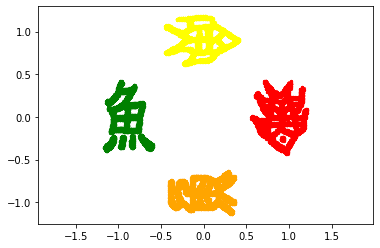

In [3]:
## GENERATE FISH IMAGES
f1 = ImageDataset('frames/fish1.jpg',noise_std=0); 
f2 = ImageDataset('frames/fish2.jpg',noise_std=0); 
f3 = ImageDataset('frames/fish3.jpg',noise_std=0); 
f4 = ImageDataset('frames/fish4.jpg',noise_std=0); 

n_inner = 8000;
n_sil = 10000 - n_inner;
dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1.2, -1], center = [-.07, .9], rotate = -np.pi/2),0); 
dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [.9, -1], center = [.9, 0], rotate = -np.pi),0); 
dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [.9, -1.0], center = [0, -.9], rotate = np.pi/2),0); 
dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [.95, -1.0], center = [-.9, 0], rotate = 0),0); 

ezshow(dat1, col='yellow')
ezshow(dat2, col='red')
ezshow(dat3, col='orange')
ezshow(dat4, col='green')

/mnt/pzpzpzp1/wassflow/LearnVelTraj.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(meshSamplePoints).to(device).float())
  0%|          | 1/300 [00:01<08:18,  1.67s/it]

Allocated: 0.58 GB  Reserved: 1.42 GB
[Loss: 1.4142 | lr: 0.0001 | n_subsample: 300] 
[Total time : 1.6699 | Iter: 1.6686 | fit: 0.2464 | reg: 0.1671 | save: 0.0000) | autograd: 1.2527]


 17%|█▋        | 51/300 [01:43<19:00,  4.58s/it]

Allocated: 0.58 GB  Reserved: 1.42 GB
[Loss: 0.1920 | lr: 0.0001 | n_subsample: 378] 
[Total time : 103.9631 | Iter: 93.7369 | fit: 0.3000 | reg: 0.2471 | save: 8.5544) | autograd: 1.4761]


 34%|███▎      | 101/300 [03:34<15:39,  4.72s/it]

Allocated: 0.58 GB  Reserved: 1.42 GB
[Loss: 0.1101 | lr: 0.0001 | n_subsample: 476] 
[Total time : 214.0755 | Iter: 101.5491 | fit: 0.2889 | reg: 0.3074 | save: 8.5499) | autograd: 1.6385]


 50%|█████     | 151/300 [05:26<11:23,  4.59s/it]

Allocated: 0.58 GB  Reserved: 1.42 GB
[Loss: 0.1075 | lr: 0.0001 | n_subsample: 600] 
[Total time : 326.8526 | Iter: 104.3059 | fit: 0.3084 | reg: 0.2223 | save: 8.4693) | autograd: 1.3802]


 67%|██████▋   | 201/300 [07:19<07:31,  4.56s/it]

Allocated: 0.58 GB  Reserved: 1.42 GB
[Loss: 0.1214 | lr: 5e-05 | n_subsample: 756] 
[Total time : 439.0355 | Iter: 103.9125 | fit: 0.3310 | reg: 0.2352 | save: 8.2688) | autograd: 1.4705]


 84%|████████▎ | 251/300 [09:13<03:42,  4.54s/it]

Allocated: 0.58 GB  Reserved: 1.42 GB
[Loss: 0.0705 | lr: 5e-05 | n_subsample: 953] 
[Total time : 553.5966 | Iter: 106.6982 | fit: 0.3403 | reg: 0.2791 | save: 7.8617) | autograd: 1.6063]


100%|██████████| 300/300 [11:08<00:00,  2.23s/it]

Allocated: 0.58 GB  Reserved: 1.42 GB
[Loss: 0.0553 | lr: 5e-05 | n_subsample: 953] 
[Total time : 668.6479 | Iter: 107.2663 | fit: 0.3158 | reg: 0.2857 | save: 7.7836) | autograd: 1.6296]


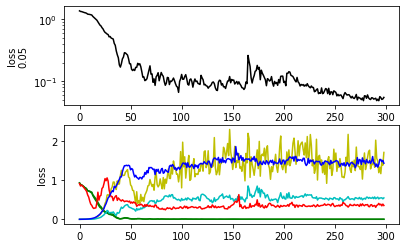

In [136]:
## TRAIN FISH1234 circle. Jerk=.01
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3, dat4)).to(device));

model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_fish1234_circle/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)

In [137]:
# RENDER ABOVE
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3, dat4)).to(device));
model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = True, Tperiod=len(keyframes)-1).to(device)
outfolder = "results/experiment_fish1234_circle/"
model.load_state(outfolder + 'models/state_final.tar')

xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
                       nsteps=20, dpiv=600, n=2000)
st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
                       dpiv=600, sigma=None, knn=12, cycle=True)

In [147]:
## TRAIN FISH1234 circle. Jerk=.01. rigid=.1, curl-pi=.1
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3, dat4)).to(device));

model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_fish1234_circle_morecurl_andrigid/"
model.load_state(outfolder + 'models/state_0050.tar')
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=953, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 5e-5, scaling = .4)

/mnt/pzpzpzp1/wassflow/LearnVelTraj.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(meshSamplePoints).to(device).float())
  0%|          | 1/300 [00:03<15:33,  3.12s/it]

Allocated: 0.29 GB  Reserved: 1.42 GB
[Loss: 1.4531 | lr: 5e-05 | n_subsample: 953] 
[Total time : 3.1238 | Iter: 3.1217 | fit: 0.5234 | reg: 0.2963 | save: 0.0000) | autograd: 2.2986]


 17%|█▋        | 51/300 [02:31<20:38,  4.97s/it]

Allocated: 0.29 GB  Reserved: 1.42 GB
[Loss: 1.4929 | lr: 5e-05 | n_subsample: 1100] 
[Total time : 151.2456 | Iter: 140.8943 | fit: 0.3583 | reg: 0.3238 | save: 7.2266) | autograd: 2.1432]


 27%|██▋       | 82/300 [04:05<10:51,  2.99s/it]


KeyboardInterrupt: 

In [148]:
# RENDER ABOVE
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3, dat4)).to(device));
model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = True, Tperiod=len(keyframes)-1).to(device)
outfolder = "results/experiment_fish1234_circle_morecurl_andrigid/"
# model.load_state(outfolder + 'models/state_final.tar')
model.load_state(outfolder + 'models/state_0050.tar')

xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
                       nsteps=20, dpiv=600, n=2000)
st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
                       dpiv=600, sigma=None, knn=12, cycle=True, lw=2)

/mnt/pzpzpzp1/wassflow/LearnVelTraj.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(meshSamplePoints).to(device).float())
  0%|          | 1/300 [00:00<03:09,  1.58it/s]

Allocated: 0.04 GB  Reserved: 1.03 GB
[Loss: 1.4142 | lr: 0.0001 | n_subsample: 300] 
[Total time : 0.6351 | Iter: 0.6342 | fit: 0.1119 | reg: 0.0890 | save: 0.0000) | autograd: 0.4308]


 17%|█▋        | 51/300 [00:37<07:26,  1.79s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.1390 | lr: 0.0001 | n_subsample: 378] 
[Total time : 37.4436 | Iter: 33.1441 | fit: 0.0998 | reg: 0.0897 | save: 3.6630) | autograd: 0.5577]


 34%|███▎      | 101/300 [01:15<06:03,  1.83s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.1245 | lr: 0.0001 | n_subsample: 476] 
[Total time : 75.2739 | Iter: 34.0856 | fit: 0.1107 | reg: 0.0971 | save: 3.7426) | autograd: 0.5434]


 50%|█████     | 151/300 [01:52<04:31,  1.82s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.1156 | lr: 0.0001 | n_subsample: 600] 
[Total time : 112.8752 | Iter: 33.7381 | fit: 0.0944 | reg: 0.0814 | save: 3.8616) | autograd: 0.5019]


 67%|██████▋   | 201/300 [02:30<03:07,  1.89s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.1259 | lr: 0.0001 | n_subsample: 756] 
[Total time : 150.5676 | Iter: 33.7116 | fit: 0.0999 | reg: 0.0975 | save: 3.9791) | autograd: 0.5305]


 84%|████████▎ | 251/300 [03:08<01:30,  1.86s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.1135 | lr: 5e-05 | n_subsample: 953] 
[Total time : 188.3963 | Iter: 33.8876 | fit: 0.0847 | reg: 0.0793 | save: 3.9390) | autograd: 0.4525]


 89%|████████▊ | 266/300 [03:18<00:25,  1.34it/s]


KeyboardInterrupt: 

In [74]:
## TRAIN MF. Jerk=.01, rigid=2
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));

model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_MF2_rigid/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)

  0%|          | 1/300 [00:00<03:04,  1.62it/s]

Allocated: 0.04 GB  Reserved: 1.03 GB
[Loss: 1.4142 | lr: 0.0001 | n_subsample: 300] 
[Total time : 0.6200 | Iter: 0.6191 | fit: 0.0922 | reg: 0.0759 | save: 0.0000) | autograd: 0.4474]


 17%|█▋        | 51/300 [00:37<07:46,  1.87s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.1831 | lr: 0.0001 | n_subsample: 378] 
[Total time : 37.4737 | Iter: 32.8240 | fit: 0.0935 | reg: 0.0831 | save: 4.0279) | autograd: 0.4340]


 34%|███▎      | 101/300 [01:15<06:07,  1.85s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.1172 | lr: 0.0001 | n_subsample: 476] 
[Total time : 75.4136 | Iter: 34.0470 | fit: 0.0942 | reg: 0.0915 | save: 3.8900) | autograd: 0.4968]


 50%|█████     | 151/300 [01:53<04:26,  1.79s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.1040 | lr: 0.0001 | n_subsample: 600] 
[Total time : 113.0945 | Iter: 33.9536 | fit: 0.0892 | reg: 0.0810 | save: 3.7249) | autograd: 0.4552]


 67%|██████▋   | 201/300 [02:30<03:06,  1.88s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.1136 | lr: 5e-05 | n_subsample: 756] 
[Total time : 150.9560 | Iter: 33.8102 | fit: 0.1070 | reg: 0.0902 | save: 4.0488) | autograd: 0.4604]


 79%|███████▉  | 238/300 [02:57<00:46,  1.34it/s]


KeyboardInterrupt: 

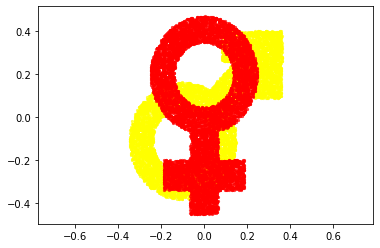

In [60]:
## GENERATE MF IMAGES
f1 = ImageDataset('frames/male.jpg',noise_std=0); 
f2 = ImageDataset('frames/female.jpg',noise_std=0); 

n_inner = 8000;
n_sil = 10000 - n_inner;
dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.1], center = [0, 0], rotate = 0),0); 
dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [1, -1.1], center = [0, 0], rotate = 0),0); 

ezshow(dat1, col='yellow')
ezshow(dat2, col='red')

/mnt/pzpzpzp1/wassflow/LearnVelTraj.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(meshSamplePoints).to(device).float())
  0%|          | 1/300 [00:00<03:27,  1.44it/s]

Allocated: 0.04 GB  Reserved: 1.02 GB
[Loss: 1.4143 | lr: 0.0001 | n_subsample: 300] 
[Total time : 0.6952 | Iter: 0.6937 | fit: 0.0843 | reg: 0.0767 | save: 0.0000) | autograd: 0.5310]


 17%|█▋        | 51/300 [00:35<07:26,  1.79s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.4322 | lr: 0.0001 | n_subsample: 378] 
[Total time : 35.7798 | Iter: 31.1586 | fit: 0.0882 | reg: 0.0673 | save: 3.9235) | autograd: 0.4004]


 34%|███▎      | 101/300 [01:10<05:36,  1.69s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.3080 | lr: 0.0001 | n_subsample: 476] 
[Total time : 70.9569 | Iter: 31.7238 | fit: 0.0863 | reg: 0.0769 | save: 3.4512) | autograd: 0.5186]


 50%|█████     | 151/300 [01:46<04:25,  1.78s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.2970 | lr: 0.0001 | n_subsample: 600] 
[Total time : 106.5074 | Iter: 31.7220 | fit: 0.1080 | reg: 0.0936 | save: 3.8269) | autograd: 0.4359]


 67%|██████▋   | 201/300 [02:22<02:54,  1.77s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.3618 | lr: 5e-05 | n_subsample: 756] 
[Total time : 142.7839 | Iter: 32.6935 | fit: 0.1028 | reg: 0.0994 | save: 3.5814) | autograd: 0.5227]


 84%|████████▎ | 251/300 [02:59<01:28,  1.80s/it]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.3162 | lr: 2.5e-05 | n_subsample: 953] 
[Total time : 179.2403 | Iter: 32.6641 | fit: 0.0928 | reg: 0.0797 | save: 3.7908) | autograd: 0.5038]


100%|██████████| 300/300 [03:34<00:00,  1.40it/s]

Allocated: 0.03 GB  Reserved: 1.03 GB
[Loss: 0.2707 | lr: 2.5e-05 | n_subsample: 953] 
[Total time : 214.8629 | Iter: 31.6494 | fit: 0.0932 | reg: 0.0837 | save: 3.9712) | autograd: 0.5222]


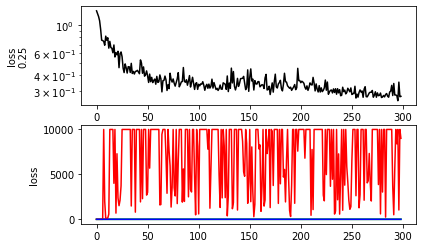

In [65]:
## TRAIN MF. Jerk=.01, rigid=2
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));

model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_MF_rigid/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)

/mnt/pzpzpzp1/wassflow/LearnVelTraj.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(meshSamplePoints).to(device).float())
  0%|          | 1/300 [00:00<03:07,  1.60it/s]

Allocated: 0.03 GB  Reserved: 1.01 GB
[Loss: 1.4142 | lr: 0.0001 | n_subsample: 300] 
[Total time : 0.6274 | Iter: 0.6263 | fit: 0.0832 | reg: 0.0823 | save: 0.0000) | autograd: 0.4586]


 17%|█▋        | 51/300 [00:35<07:25,  1.79s/it]

Allocated: 0.03 GB  Reserved: 1.02 GB
[Loss: 0.5581 | lr: 0.0001 | n_subsample: 378] 
[Total time : 35.1488 | Iter: 30.6600 | fit: 0.0877 | reg: 0.0798 | save: 3.8600) | autograd: 0.4628]


 34%|███▎      | 101/300 [01:11<06:15,  1.89s/it]

Allocated: 0.03 GB  Reserved: 1.02 GB
[Loss: 0.4963 | lr: 0.0001 | n_subsample: 476] 
[Total time : 71.0976 | Iter: 31.8908 | fit: 0.0819 | reg: 0.0695 | save: 4.0568) | autograd: 0.4971]


 50%|█████     | 151/300 [01:49<04:39,  1.87s/it]

Allocated: 0.03 GB  Reserved: 1.02 GB
[Loss: 0.5125 | lr: 0.0001 | n_subsample: 600] 
[Total time : 109.5515 | Iter: 34.5990 | fit: 0.0873 | reg: 0.1097 | save: 3.8513) | autograd: 0.5431]


 67%|██████▋   | 201/300 [02:29<03:04,  1.86s/it]

Allocated: 0.03 GB  Reserved: 1.02 GB
[Loss: 0.3814 | lr: 0.0001 | n_subsample: 756] 
[Total time : 149.2541 | Iter: 35.9197 | fit: 0.1049 | reg: 0.0836 | save: 3.7813) | autograd: 0.5521]


 84%|████████▎ | 251/300 [03:09<01:32,  1.88s/it]

Allocated: 0.03 GB  Reserved: 1.02 GB
[Loss: 0.3118 | lr: 0.0001 | n_subsample: 953] 
[Total time : 189.5597 | Iter: 36.4566 | fit: 0.1177 | reg: 0.0937 | save: 3.8477) | autograd: 0.5663]


100%|██████████| 300/300 [03:49<00:00,  1.31it/s]

Allocated: 0.03 GB  Reserved: 1.02 GB
[Loss: 0.3109 | lr: 0.0001 | n_subsample: 953] 
[Total time : 229.2548 | Iter: 36.0819 | fit: 0.1037 | reg: 0.0811 | save: 3.6115) | autograd: 0.5136]


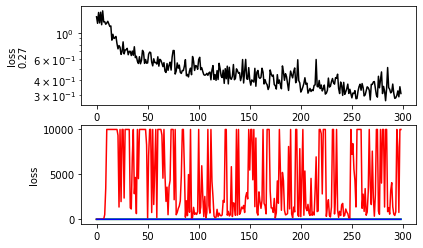

In [61]:
## TRAIN MF. Jerk=.01
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2)).to(device));

model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_MF_base/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)

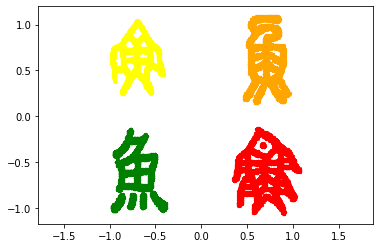

In [40]:
## GENERATE FISH IMAGES
f1 = ImageDataset('frames/fish1.jpg',noise_std=0); 
f2 = ImageDataset('frames/fish2.jpg',noise_std=0); 
f3 = ImageDataset('frames/fish3.jpg',noise_std=0); 
f4 = ImageDataset('frames/fish4.jpg',noise_std=0); 

n_inner = 8000;
n_sil = 10000 - n_inner;
dat1 = torch.cat(f1.sample(n_inner, n_sil, scale = [1, -1.1], center = [-.7, .6], rotate = 0),0); 
dat2 = torch.cat(f2.sample(n_inner, n_sil, scale = [1, -1.1], center = [.7, -.6], rotate = 0),0); 
dat3 = torch.cat(f3.sample(n_inner, n_sil, scale = [1, -1.1], center = [.7, .6], rotate = 0),0); 
dat4 = torch.cat(f4.sample(n_inner, n_sil, scale = [1, -1.1], center = [-.7, -.6], rotate = 0),0); 

ezshow(dat1, col='yellow')
ezshow(dat2, col='red')
ezshow(dat3, col='orange')
ezshow(dat4, col='green')

/mnt/pzpzpzp1/wassflow/LearnVelTraj.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(meshSamplePoints).to(device).float())
  0%|          | 1/300 [00:01<08:46,  1.76s/it]

Allocated: 0.04 GB  Reserved: 0.99 GB
[Loss: 1.4143 | lr: 0.0001 | n_subsample: 300] 
[Total time : 1.7621 | Iter: 1.7605 | fit: 0.2533 | reg: 0.2061 | save: 0.0000) | autograd: 1.2984]


 17%|█▋        | 51/300 [01:44<18:24,  4.43s/it]

Allocated: 0.03 GB  Reserved: 0.99 GB
[Loss: 0.2327 | lr: 0.0001 | n_subsample: 378] 
[Total time : 104.6191 | Iter: 95.3438 | fit: 0.3409 | reg: 0.2402 | save: 7.5109) | autograd: 1.5946]


 34%|███▎      | 101/300 [03:47<14:42,  4.43s/it]

Allocated: 0.03 GB  Reserved: 0.99 GB
[Loss: 0.2681 | lr: 5e-05 | n_subsample: 476] 
[Total time : 227.1926 | Iter: 115.3376 | fit: 0.3866 | reg: 0.2328 | save: 7.2337) | autograd: 1.5654]


 50%|█████     | 151/300 [05:48<10:57,  4.41s/it]

Allocated: 0.03 GB  Reserved: 0.99 GB
[Loss: 0.4412 | lr: 2.5e-05 | n_subsample: 600] 
[Total time : 348.9586 | Iter: 114.5010 | fit: 0.3569 | reg: 0.2886 | save: 7.2634) | autograd: 1.6906]


 67%|██████▋   | 201/300 [07:51<07:33,  4.59s/it]

Allocated: 0.03 GB  Reserved: 0.99 GB
[Loss: 0.4429 | lr: 1.25e-05 | n_subsample: 756] 
[Total time : 471.0927 | Iter: 114.8102 | fit: 0.3559 | reg: 0.2746 | save: 7.3222) | autograd: 1.5808]


 84%|████████▎ | 251/300 [09:55<03:41,  4.51s/it]

Allocated: 0.03 GB  Reserved: 0.99 GB
[Loss: 0.1771 | lr: 1.25e-05 | n_subsample: 953] 
[Total time : 595.1450 | Iter: 116.7083 | fit: 0.3815 | reg: 0.2988 | save: 7.3428) | autograd: 1.6202]


100%|██████████| 300/300 [11:56<00:00,  2.39s/it]

Allocated: 0.03 GB  Reserved: 0.99 GB
[Loss: 0.1040 | lr: 1.25e-05 | n_subsample: 953] 
[Total time : 716.7629 | Iter: 114.2267 | fit: 0.3655 | reg: 0.3002 | save: 7.3898) | autograd: 1.7368]


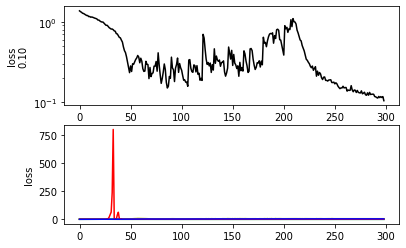

In [50]:
## TRAIN FISH1234. Jerk=.01, curl=3
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3, dat4)).to(device));

model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_fish1234_min3curl/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)

In [51]:
# RENDER FISH1234. Jerk=.01, curl=3
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3, dat4)).to(device));
model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True, Tperiod=len(keyframes)-1).to(device)
outfolder = "results/experiment_fish1234_min3curl/"
model.load_state(outfolder + 'models/state_final.tar')

xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
                       nsteps=20, dpiv=600, n=2000)
st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
                       dpiv=600, sigma=None, knn=12, cycle=True)

/mnt/pzpzpzp1/wassflow/LearnVelTraj.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(meshSamplePoints).to(device).float())
  0%|          | 1/300 [00:01<08:16,  1.66s/it]

Allocated: 0.05 GB  Reserved: 0.99 GB
[Loss: 1.4142 | lr: 0.0001 | n_subsample: 300] 
[Total time : 1.6610 | Iter: 1.6594 | fit: 0.2434 | reg: 0.1921 | save: 0.0000) | autograd: 1.2209]


 17%|█▋        | 51/300 [01:45<17:52,  4.31s/it]

Allocated: 0.03 GB  Reserved: 0.99 GB
[Loss: 0.5209 | lr: 0.0001 | n_subsample: 378] 
[Total time : 105.2580 | Iter: 95.9364 | fit: 0.3437 | reg: 0.1897 | save: 7.6591) | autograd: 1.3182]


 34%|███▎      | 101/300 [03:49<15:07,  4.56s/it]

Allocated: 0.03 GB  Reserved: 0.99 GB
[Loss: 0.1761 | lr: 0.0001 | n_subsample: 476] 
[Total time : 229.2284 | Iter: 116.5423 | fit: 0.3739 | reg: 0.2689 | save: 7.4254) | autograd: 1.7431]


 50%|█████     | 151/300 [05:55<11:28,  4.62s/it]

Allocated: 0.03 GB  Reserved: 0.99 GB
[Loss: 0.1539 | lr: 0.0001 | n_subsample: 600] 
[Total time : 355.2608 | Iter: 118.4871 | fit: 0.3641 | reg: 0.2838 | save: 7.5440) | autograd: 1.6461]


 67%|██████▋   | 201/300 [08:04<07:44,  4.69s/it]

Allocated: 0.03 GB  Reserved: 0.99 GB
[Loss: 0.6395 | lr: 5e-05 | n_subsample: 756] 
[Total time : 484.4383 | Iter: 121.8992 | fit: 0.3713 | reg: 0.2942 | save: 7.2771) | autograd: 1.7430]


 84%|████████▎ | 251/300 [10:15<03:42,  4.54s/it]

Allocated: 0.03 GB  Reserved: 0.99 GB
[Loss: 0.1229 | lr: 2.5e-05 | n_subsample: 953] 
[Total time : 615.0932 | Iter: 123.6742 | fit: 0.3708 | reg: 0.2979 | save: 6.9787) | autograd: 1.8265]


100%|██████████| 300/300 [12:23<00:00,  2.48s/it]

Allocated: 0.03 GB  Reserved: 0.99 GB
[Loss: 0.0903 | lr: 2.5e-05 | n_subsample: 953] 
[Total time : 743.0334 | Iter: 120.4441 | fit: 0.3626 | reg: 0.3111 | save: 7.4941) | autograd: 1.7717]


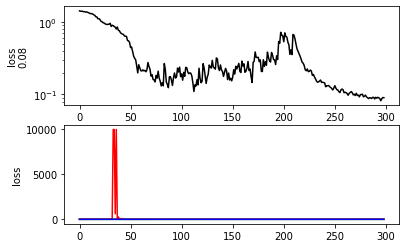

In [48]:
## TRAIN FISH1234. Jerk=.01, curl=1
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3, dat4)).to(device));

model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_fish1234_mincurl/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)

/mnt/pzpzpzp1/wassflow/LearnVelTraj.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(meshSamplePoints).to(device).float())
  0%|          | 1/300 [00:01<09:12,  1.85s/it]

Allocated: 0.05 GB  Reserved: 1.0 GB
[Loss: 1.4142 | lr: 0.0001 | n_subsample: 300] 
[Total time : 1.8488 | Iter: 1.8475 | fit: 0.2582 | reg: 0.2061 | save: 0.0000) | autograd: 1.3796]


 17%|█▋        | 51/300 [01:47<19:06,  4.60s/it]

Allocated: 0.03 GB  Reserved: 1.0 GB
[Loss: 0.2806 | lr: 0.0001 | n_subsample: 378] 
[Total time : 107.8846 | Iter: 98.4241 | fit: 0.3488 | reg: 0.2998 | save: 7.6107) | autograd: 1.6644]


 34%|███▎      | 101/300 [03:50<14:45,  4.45s/it]

Allocated: 0.03 GB  Reserved: 1.0 GB
[Loss: 0.0799 | lr: 0.0001 | n_subsample: 476] 
[Total time : 230.3337 | Iter: 114.9874 | fit: 0.3471 | reg: 0.2256 | save: 7.4600) | autograd: 1.5489]


 50%|█████     | 151/300 [05:53<11:26,  4.61s/it]

Allocated: 0.03 GB  Reserved: 1.0 GB
[Loss: 0.0714 | lr: 0.0001 | n_subsample: 600] 
[Total time : 353.3889 | Iter: 115.5960 | fit: 0.3541 | reg: 0.3052 | save: 7.4567) | autograd: 1.7868]


 67%|██████▋   | 201/300 [07:58<07:46,  4.72s/it]

Allocated: 0.03 GB  Reserved: 1.0 GB
[Loss: 0.1048 | lr: 5e-05 | n_subsample: 756] 
[Total time : 478.6190 | Iter: 117.4761 | fit: 0.3444 | reg: 0.2570 | save: 7.7523) | autograd: 1.6729]


 84%|████████▎ | 251/300 [10:05<03:47,  4.65s/it]

Allocated: 0.03 GB  Reserved: 1.0 GB
[Loss: 0.0581 | lr: 5e-05 | n_subsample: 953] 
[Total time : 605.9871 | Iter: 119.4879 | fit: 0.3579 | reg: 0.2180 | save: 7.8780) | autograd: 1.5187]


100%|██████████| 300/300 [12:11<00:00,  2.44s/it]

Allocated: 0.03 GB  Reserved: 1.0 GB
[Loss: 0.0424 | lr: 5e-05 | n_subsample: 953] 
[Total time : 731.2351 | Iter: 117.9243 | fit: 0.3798 | reg: 0.2288 | save: 7.3214) | autograd: 1.5924]


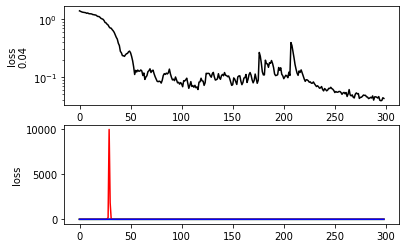

In [55]:
## TRAIN FISH1234. Jerk=.01
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3, dat4)).to(device));

model = FfjordModel(sigmac = 2, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 1, in_features=3, out_features=2, incrementalMask = True,  Tperiod = None).to(device)
outfolder = "results/experiment_fish1234/"
model, losses, separate_losses, lrs, n_subs, separate_times = learn_vel_trajectory(keyframes, n_iters = 300, stepsperbatch=50, n_subsample=300, model=model, outname=outfolder, sqrtfitloss=True, detachTZM = False, lr = 1e-4, scaling = .4)

In [56]:
# RENDER FISH1234
keyframes, __ = ImageDataset.normalize_samples(torch.stack((dat1, dat2, dat3, dat4)).to(device));
model = FfjordModel(sigmac = 4, n_freq = 100, hidden_layers=3, hidden_features=512, tdiv = 2, in_features=3, out_features=2, incrementalMask = True, Tperiod=len(keyframes)-1).to(device)
outfolder = "results/experiment_fish1234/"
model.load_state(outfolder + 'models/state_final.tar')

xt_trajs = st.save_trajectory_2d(model, keyframes, savedir=outfolder, savename='render',
                       nsteps=20, dpiv=600, n=2000)
st.render_2d(model, keyframes, xt_trajs, savedir=outfolder, savename='render',
                       dpiv=600, sigma=None, knn=12, cycle=True)

In [ ]:
## GENERATE BUNCH OF IMAGES
im1 = ImageDataset('frames/butterfly.jpg'); 
im1b = ImageDataset('frames/butterflyfilled.jpg'); 
im2 = ImageDataset('frames/caterpillar.png', noise_std = .005); 
im3 = ImageDataset('frames/circle.jpeg'); 
im4 = ImageDataset('frames/baldhead.jpeg'); 
im5 = ImageDataset('frames/square.png'); 
im6 = ImageDataset('frames/cat1.png'); 

n_inner = 7000;
n_sil = 10000 - n_inner;
d2 = im2.sample(n_inner, n_sil, scale = [-1, -1], center = [0.05, -.5]); 
d1a = im1.sample(n_inner, n_sil, center = [0, 0]); 
d1b = im1b.sample(n_inner, n_sil, center = [0, 0]); 
d3 = im3.sample(n_inner, n_sil, center = [1, .5]); 
d4 = im4.sample(n_inner, n_sil, center = [1, -.5]); 
d5 = im5.sample(n_inner, n_sil, center = [1.9, .3]); 
d6 = im6.sample(n_inner, n_sil, center = [2, -.3]); 

dat1 = torch.cat((d1a[0], d1b[1]),0)
dat2 = torch.cat(d2,0)
dat3 = torch.cat(d3,0)
dat4 = torch.cat(d4,0)
dat5 = torch.cat(d5,0)
dat6 = torch.cat(d6,0)

ezshow(dat1, col='yellow')
ezshow(dat2, col='red')
ezshow(dat3, col='orange')
ezshow(dat4, col='green')
ezshow(dat5, col='blue')
ezshow(dat6, col='magenta')